In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

In [6]:
# 1. Load Data
df = pd.read_csv('../data/kidney_diseases_data/kidney_disease.csv')

In [7]:
# 2. Remove columns with mostly nulls or user-requested drops
null_cols = df.columns[df.isnull().mean() > 0.3].tolist()
drops = ['sod', 'pot', 'su', 'ba', 'rc']
df.drop(columns=[col for col in drops+null_cols if col in df.columns], inplace=True)

In [8]:
# 3. Define categorical columns (excluding target) -- adjust after drops if needed
target = 'classification'
cat_cols = [
    'rbc', 'pc', 'pcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'
]
# Remove any missing categorical columns due to drops
cat_cols = [col for col in cat_cols if col in df.columns]

In [9]:
# 4. Fill missing values
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # fill cats with most frequent
num_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != target]
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())   # fill nums with median

In [10]:
# 5. Feature engineering (optional)
# If you want to add plus/minus mean features:
for col in num_cols:
    df[f"{col}_plus"] = df[col] + df[col].mean()
    df[f"{col}_minus"] = df[col] - df[col].mean()

In [11]:
# 6. Prepare X, y
X = df.drop(target, axis=1)
y = df[target].astype(str)

In [12]:
# 7. Set up preprocessing pipeline for deployment
# Find all categorical columns left after engineering
categorical_features = [col for col in X.columns if X[col].dtype == "object" or col in cat_cols]
numeric_features = [col for col in X.columns if col not in categorical_features]

In [13]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [14]:
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(penalty='l2', C=0.1, max_iter=1000, random_state=42))
])

In [15]:
# 8. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
# 9. Train and cross-validate
scores = cross_val_score(pipe, X, y, cv=5)
pipe.fit(X_train, y_train)
print("Cross-validated accuracy:", scores.mean())

c:\Users\Asus\anaconda3\envs\allpurpose\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validated accuracy: 0.9875


In [17]:
# 10. Evaluate
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         ckd       1.00      1.00      1.00        50
      notckd       1.00      1.00      1.00        30

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



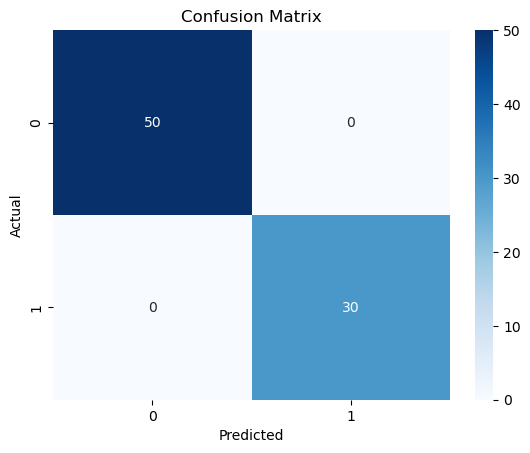

In [18]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
try:
    y_pred_probs = pipe.predict_proba(X_test)[:, 1] if len(pipe.classes_) == 2 else None
    if y_pred_probs is not None:
        fpr, tpr, _ = roc_curve(y_test.astype(int), y_pred_probs.astype(float))
        roc_auc = roc_auc_score(y_test.astype(int), y_pred_probs.astype(float))
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.2f})")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Binary)")
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("Multiclass ROC not implemented in this snippet.")
except Exception as e:
    print("Error in ROC/AUC calculation:", e)

Multiclass ROC not implemented in this snippet.


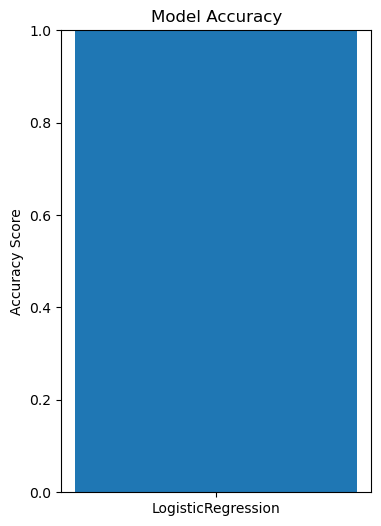

In [20]:
acc_score = accuracy_score(y_test, y_pred)
plt.figure(figsize=(4,6))
plt.bar(['LogisticRegression'], [acc_score])
plt.ylim(0,1)
plt.ylabel("Accuracy Score")
plt.title("Model Accuracy")
plt.show()

In [22]:
# 11. Save pipeline (for Flask deployment)
joblib.dump(pipe, "../trained_models/kidney_logreg_pipeline.pkl")
print("Pipeline saved as /trained_models_kidney_logreg_pipeline.pkl")

Pipeline saved as /trained_models_kidney_logreg_pipeline.pkl
